In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
idx = pd.MultiIndex

# Description

EDA for hyper param study based on query about ./ST/ECSS-E-ST-10-03-Rev.1(31May2022).pdf. The goal is to identify hyper params that lead to best performance. Relies on reply completness score (% checked key review points) and absence of errors and halucination.

The main assumption for the evaluation is:
- Given a standard paragraph, extract a topic, formulate a query, formulate key review points mentioned in the paragraph -> evaluate RAG
- Or, Known that the information is there, let’s check if RAG retrieves it entirely.

The performance (completness_score) is evaluated for different scenarios, without mistakes, without halucination, without both, with mistakes.

> Main Outcome for narrow queries
> best performer are:
> - llama2 with 2024_256<br>
> - mistral with 512_64 <br>
<br>

The performance isi evaluated also for complex and open questions, in general with poor completness_scores
> - increasing k with an open / complex question, didn't improve the performance, k=3 seems ok

Next steps
2024_256 and 512_64 embeddings are for both models, the experiment is extend to a pool of experts, for llama2 with 2024_256, k=3-5

# [1] User Input

In [3]:
eval_xlsx = 'eval/240511_RAG_eval_240518-forEDA.xlsx'

# [2] Load Data

In [4]:
df = pd.read_excel(eval_xlsx, sheet_name=None)

In [5]:
dfs_dict = {}
for sheet_name, df0 in df.items():
    if sheet_name[:1] == 'q':
        print(sheet_name)
        df0.dropna(axis=1, how='all', inplace=True)
        dfs_dict.update({sheet_name : df0})

q1_res-search
q2_pow-spect
q4_notching
q5_tina
q6_acceptance SA
q6_accept SA_k5
q6_accept SA_k10


# [3] EDA 

In [6]:
dfs = pd.concat(dfs_dict, names=['query_survey'], axis=0)
dfs.dropna(axis=1, how='all')
dfs.rename({'completness score' : 'completeness_score'}, axis=1)
dfs['emb'] = dfs['emb'].apply(lambda X: "_".join(X.split("_")[-2:]))
dfs.columns = [col.replace(" ", "_") for col in dfs.columns]
dfs.reset_index(inplace=True)
dfs = dfs.drop('level_1', axis=1)
dfs

,query_survey,sys_template,query,emb,score_kwargs,model,response,expected,helpful,incorrect_information,completeness_score,hallucinated,comment,LEN,source_documents,source_ref,out_of_ref_doc_info_used
0,q1_res-search,template_1,What is the purpose of a resonance search?,256_32,"score_thres 0.55, k=3",mistral,"The purpose of a resonance search, as outlined...",[x] resonance freqs\n[] before/after\n[x] inte...,True,False,0.625,False,NaN,418,NaN,NaN,NaN
1,q1_res-search,template_1,What is the purpose of a resonance search?,256_32,"score_thres 0.55, k=3",llama2,FINAL ANSWER:\nThe purpose of a resonance sear...,[x] resonance freqs\n[] before/after\n[x] inte...,True,False,0.625,False,NaN,440,NaN,NaN,NaN
2,q1_res-search,template_1,What is the purpose of a resonance search?,256_32,"score_thres 0.55, k=3",llama3,The purpose of a resonance search is to determ...,[x] resonance freqs\n[] before/after\n[x] inte...,True,False,0.250,False,NaN,129,NaN,NaN,NaN
3,q1_res-search,template_1,What is the purpose of a resonance search?,512_64,"score_thres 0.55, k=3",mistral,A resonance search is a test procedure perfor...,[x] resonance freqs\n[x] before/after\n[x] int...,True,False,0.875,False,NaN,795,NaN,NaN,NaN
4,q1_res-search,template_1,What is the purpose of a resonance search?,512_64,"score_thres 0.55, k=3",llama2,The purpose of a resonance search is to determ...,[x] resonance freqs\n[x] before/after\n[x] int...,True,False,0.875,False,MISTRAL response was more compact,1446,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,1024_128,"score_thres 0.55, k=3",llama2,The content of ECSS-E-ST-10-03C Rev.1 dated Ma...,"[] For k (solar array), the random vibration t...",False,True,0.100,False,NaN,1887,['ECSS -E-ST-10-03C Rev.1 31 May 2022 55 Table...,"[{'page': 54, 'source': 'ST/ECSS-E-ST-10-03-Re...",False
77,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,1024_128,"score_thres 0.55, k=3",llama3,Based on the provided sections from various do...,"[] For k (solar array), the random vibration t...",False,True,0.000,False,NaN,1263,['ECSS -E-ST-10-03C Rev.1 31 May 2022 55 Table...,"[{'page': 54, 'source': 'ST/ECSS-E-ST-10-03-Re...",False
78,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,2024_256,"score_thres 0.55, k=3",mistral,The given text appears to be extracts from a ...,"[x] For k (solar array), the random vibration ...",False,True,0.200,False,NaN,931,['equipment. ECSS- E-ST-10-03_0750456 d. In l...,"[{'page': 81, 'source': 'ST/ECSS-E-ST-10-03-Re...",False
79,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,2024_256,"score_thres 0.55, k=3",llama2,The ECSS-E-ST-10-03 standard outlines the requ...,"[] For k (solar array), the random vibration t...",False,True,0.000,False,NaN,1552,['equipment. ECSS- E-ST-10-03_0750456 d. In l...,"[{'page': 81, 'source': 'ST/ECSS-E-ST-10-03-Re...",False


In [7]:
dfs.isnull().sum()

query_survey                 0
sys_template                 0
query                        0
emb                          0
score_kwargs                 0
model                        0
response                     0
expected                     0
helpful                      0
incorrect_information        0
completeness_score           0
hallucinated                 0
comment                     64
LEN                          0
source_documents             9
source_ref                   9
out_of_ref_doc_info_used    33
dtype: int64

<Axes: >

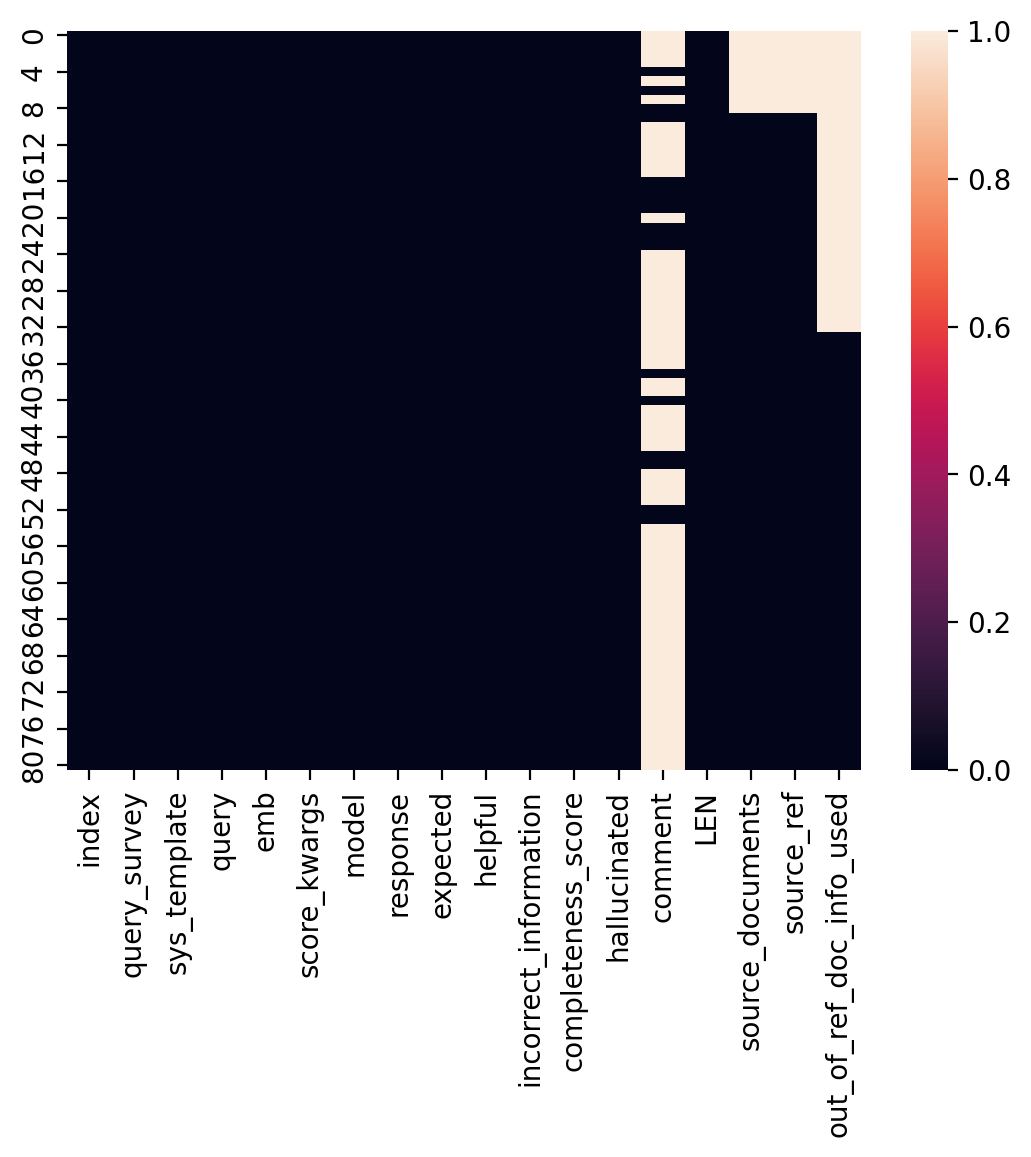

In [8]:
sns.heatmap(dfs.reset_index().isnull())

In [9]:
#dfs = dfs.reset_index().drop('level_1', axis=1).set_index(['sys_template', 'query_survey', 'query', 'emb', 'score_kwargs', 'model'])

In [10]:
dfs

,query_survey,sys_template,query,emb,score_kwargs,model,response,expected,helpful,incorrect_information,completeness_score,hallucinated,comment,LEN,source_documents,source_ref,out_of_ref_doc_info_used
0,q1_res-search,template_1,What is the purpose of a resonance search?,256_32,"score_thres 0.55, k=3",mistral,"The purpose of a resonance search, as outlined...",[x] resonance freqs\n[] before/after\n[x] inte...,True,False,0.625,False,NaN,418,NaN,NaN,NaN
1,q1_res-search,template_1,What is the purpose of a resonance search?,256_32,"score_thres 0.55, k=3",llama2,FINAL ANSWER:\nThe purpose of a resonance sear...,[x] resonance freqs\n[] before/after\n[x] inte...,True,False,0.625,False,NaN,440,NaN,NaN,NaN
2,q1_res-search,template_1,What is the purpose of a resonance search?,256_32,"score_thres 0.55, k=3",llama3,The purpose of a resonance search is to determ...,[x] resonance freqs\n[] before/after\n[x] inte...,True,False,0.250,False,NaN,129,NaN,NaN,NaN
3,q1_res-search,template_1,What is the purpose of a resonance search?,512_64,"score_thres 0.55, k=3",mistral,A resonance search is a test procedure perfor...,[x] resonance freqs\n[x] before/after\n[x] int...,True,False,0.875,False,NaN,795,NaN,NaN,NaN
4,q1_res-search,template_1,What is the purpose of a resonance search?,512_64,"score_thres 0.55, k=3",llama2,The purpose of a resonance search is to determ...,[x] resonance freqs\n[x] before/after\n[x] int...,True,False,0.875,False,MISTRAL response was more compact,1446,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,1024_128,"score_thres 0.55, k=3",llama2,The content of ECSS-E-ST-10-03C Rev.1 dated Ma...,"[] For k (solar array), the random vibration t...",False,True,0.100,False,NaN,1887,['ECSS -E-ST-10-03C Rev.1 31 May 2022 55 Table...,"[{'page': 54, 'source': 'ST/ECSS-E-ST-10-03-Re...",False
77,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,1024_128,"score_thres 0.55, k=3",llama3,Based on the provided sections from various do...,"[] For k (solar array), the random vibration t...",False,True,0.000,False,NaN,1263,['ECSS -E-ST-10-03C Rev.1 31 May 2022 55 Table...,"[{'page': 54, 'source': 'ST/ECSS-E-ST-10-03-Re...",False
78,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,2024_256,"score_thres 0.55, k=3",mistral,The given text appears to be extracts from a ...,"[x] For k (solar array), the random vibration ...",False,True,0.200,False,NaN,931,['equipment. ECSS- E-ST-10-03_0750456 d. In l...,"[{'page': 81, 'source': 'ST/ECSS-E-ST-10-03-Re...",False
79,q6_accept SA_k10,template_1,what are the acceptance test criteria for a so...,2024_256,"score_thres 0.55, k=3",llama2,The ECSS-E-ST-10-03 standard outlines the requ...,"[] For k (solar array), the random vibration t...",False,True,0.000,False,NaN,1552,['equipment. ECSS- E-ST-10-03_0750456 d. In l...,"[{'page': 81, 'source': 'ST/ECSS-E-ST-10-03-Re...",False


In [11]:
dfs[['model', 'completeness_score']].groupby('model').describe()#.sort_values()

completeness_score                                               \
                     count      mean       std  min       25%       50%   
model                                                                     
llama2                27.0  0.453704  0.378949  0.0  0.100000  0.400000   
llama3                27.0  0.368154  0.302872  0.0  0.100000  0.300000   
mistral               27.0  0.419212  0.366057  0.0  0.091667  0.333333   

                        
              75%  max  
model                   
llama2   0.816667  1.0  
llama3   0.633333  1.0  
mistral  0.708333  1.0

In [12]:
dfs[['emb', 'completeness_score']].groupby('emb').describe()#.sort_values(['completeness_score', 'mean'], ascending=False)

completeness_score                                               \
                      count      mean       std  min       25%       50%   
emb                                                                        
1024_128               21.0  0.433189  0.337227  0.0  0.181818  0.500000   
2024_256               18.0  0.474074  0.358930  0.0  0.200000  0.333333   
256_32                 21.0  0.310091  0.320726  0.0  0.083333  0.100000   
512_64                 21.0  0.446032  0.378141  0.0  0.100000  0.333333   

                              
               75%       max  
emb                           
1024_128  0.666667  1.000000  
2024_256  0.791667  1.000000  
256_32    0.625000  0.833333  
512_64    0.800000  1.000000

In [13]:
dfs[['emb', 'model', 'completeness_score']].groupby(['emb', 'model']).describe()

completeness_score                                          \
                              count      mean       std       min       25%   
emb      model                                                                
1024_128 llama2                 7.0  0.495238  0.413848  0.000000  0.150000   
         llama3                 7.0  0.331926  0.275953  0.000000  0.090909   
         mistral                7.0  0.472403  0.336755  0.000000  0.190909   
2024_256 llama2                 6.0  0.572222  0.431234  0.000000  0.250000   
         llama3                 6.0  0.450000  0.319548  0.200000  0.225000   
         mistral                6.0  0.400000  0.362093  0.100000  0.125000   
256_32   llama2                 7.0  0.355952  0.362307  0.000000  0.091667   
         llama3                 7.0  0.304762  0.318375  0.000000  0.091667   
         mistral                7.0  0.269558  0.325349  0.000000  0.000000   
512_64   llama2                 7.0  0.408333  0.367644  0.000000  0.091667   
         llama3                 7.0  0.397619  0.347801  0.083333  0.100000   
         mistral                7.0  0.532143  0.455482  0.000000  0.091667   

                                                
                       50%       75%       max  
emb      model                                  
1024_128 llama2   0.500000  0.833333  1.000000  
         llama3   0.375000  0.550000  0.666667  
         mistral  0.625000  0.733333  0.833333  
2024_256 llama2   0.616667  0.958333  1.000000  
         llama3   0.316667  0.583333  1.000000  
         mistral  0.266667  0.583333  1.000000  
256_32   llama2   0.100000  0.687500  0.833333  
         llama3   0.200000  0.458333  0.833333  
         mistral  0.083333  0.526786  0.750000  
512_64   llama2   0.333333  0.733333  0.875000  
         llama3   0.333333  0.583333  1.000000  
         mistral  0.666667  0.937500  1.000000

In [14]:
dfs[['emb', 'model', 'completeness_score']].groupby(['model', 'emb']).describe()

completeness_score                                          \
                              count      mean       std       min       25%   
model   emb                                                                   
llama2  1024_128                7.0  0.495238  0.413848  0.000000  0.150000   
        2024_256                6.0  0.572222  0.431234  0.000000  0.250000   
        256_32                  7.0  0.355952  0.362307  0.000000  0.091667   
        512_64                  7.0  0.408333  0.367644  0.000000  0.091667   
llama3  1024_128                7.0  0.331926  0.275953  0.000000  0.090909   
        2024_256                6.0  0.450000  0.319548  0.200000  0.225000   
        256_32                  7.0  0.304762  0.318375  0.000000  0.091667   
        512_64                  7.0  0.397619  0.347801  0.083333  0.100000   
mistral 1024_128                7.0  0.472403  0.336755  0.000000  0.190909   
        2024_256                6.0  0.400000  0.362093  0.100000  0.125000   
        256_32                  7.0  0.269558  0.325349  0.000000  0.000000   
        512_64                  7.0  0.532143  0.455482  0.000000  0.091667   

                                                
                       50%       75%       max  
model   emb                                     
llama2  1024_128  0.500000  0.833333  1.000000  
        2024_256  0.616667  0.958333  1.000000  
        256_32    0.100000  0.687500  0.833333  
        512_64    0.333333  0.733333  0.875000  
llama3  1024_128  0.375000  0.550000  0.666667  
        2024_256  0.316667  0.583333  1.000000  
        256_32    0.200000  0.458333  0.833333  
        512_64    0.333333  0.583333  1.000000  
mistral 1024_128  0.625000  0.733333  0.833333  
        2024_256  0.266667  0.583333  1.000000  
        256_32    0.083333  0.526786  0.750000  
        512_64    0.666667  0.937500  1.000000

In [15]:
display(dfs[['model', 'completeness_score']].groupby(['model']).mean().sort_values(by='completeness_score', ascending=False))
display(dfs[['emb', 'completeness_score']].groupby(['emb']).mean().sort_values(by='completeness_score', ascending=False))
dfs[['emb', 'model', 'completeness_score']].groupby(['model', 'emb']).mean().sort_values(by='completeness_score', ascending=False)

,completeness_score
model,
llama2,0.453704
mistral,0.419212
llama3,0.368154


,completeness_score
emb,
2024_256,0.474074
512_64,0.446032
1024_128,0.433189
256_32,0.310091


,,completeness_score
model,emb,
llama2,2024_256,0.572222
mistral,512_64,0.532143
llama2,1024_128,0.495238
mistral,1024_128,0.472403
llama3,2024_256,0.450000
llama2,512_64,0.408333
mistral,2024_256,0.400000
llama3,512_64,0.397619
llama2,256_32,0.355952


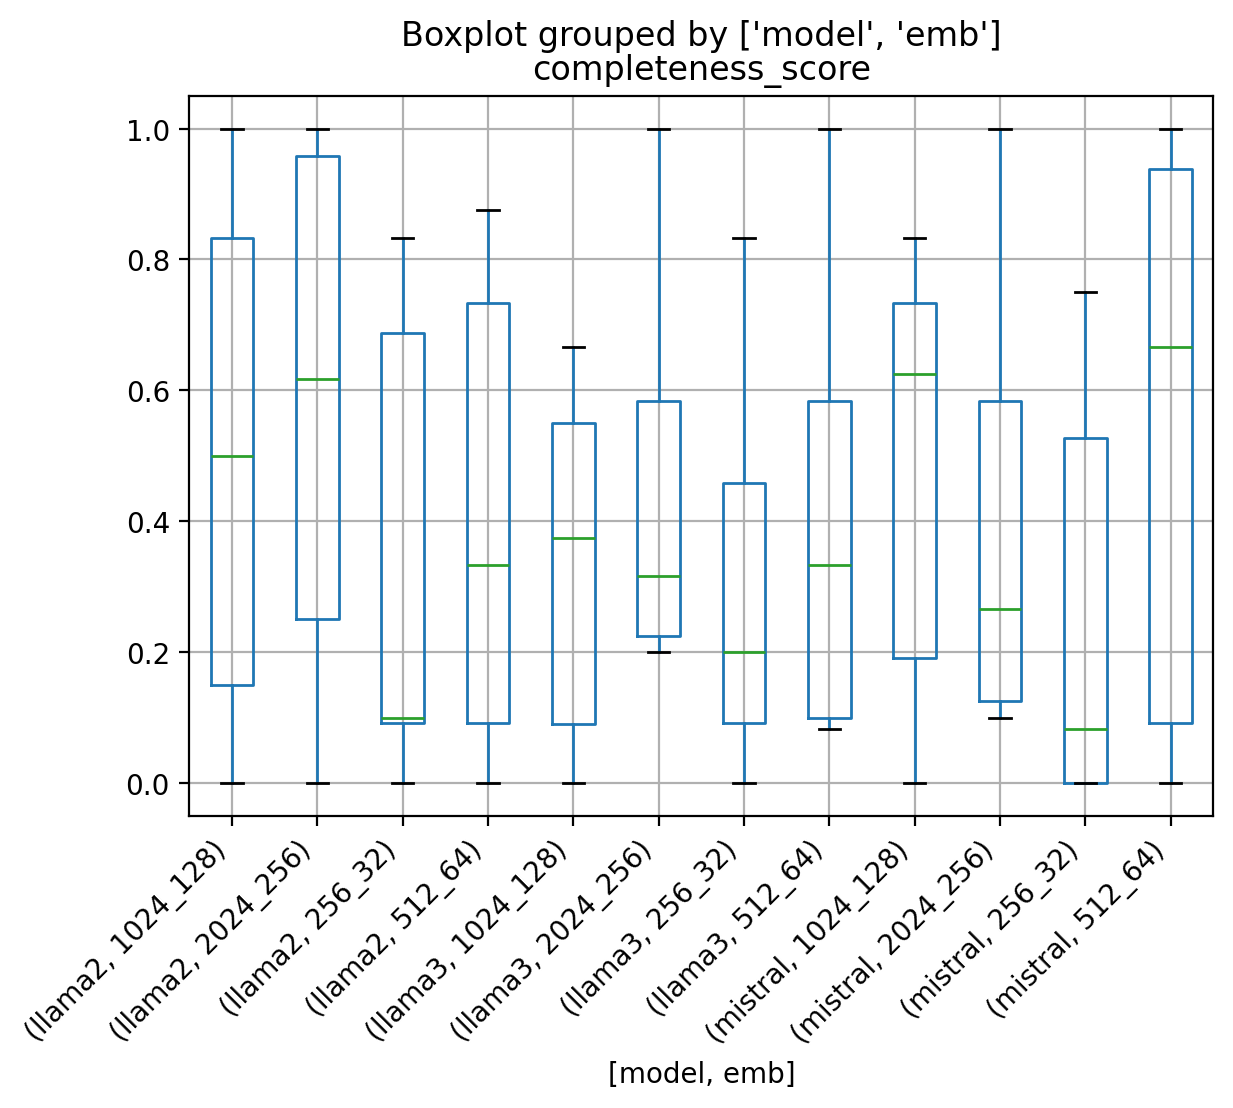

In [16]:
plot_df = dfs[['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=['model', 'emb'], rot=45)
plt.xticks(rotation=45, ha='right');

In [17]:
dfs.columns

Index(['query_survey', 'sys_template', 'query', 'emb', 'score_kwargs', 'model',
       'response', 'expected', 'helpful', 'incorrect_information',
       'completeness_score', 'hallucinated', 'comment', 'LEN',
       'source_documents', 'source_ref', 'out_of_ref_doc_info_used'],
      dtype='object')

# Conditions, eval filtering

In [18]:
cnd_is_incorrect = dfs['incorrect_information'] == True
cnd_is_correct = dfs['incorrect_information'] == False
cnd_is_helpful = dfs['helpful'] == True
cnd_is_hallucinated = dfs['hallucinated'] == True
cnd_wo_hallucinations = dfs['hallucinated'] == False
cnd_is_complex_q = (dfs['query_survey'] == 'q6_acceptance SA') | (dfs['query_survey'] == 'q6_accept SA_k5') | (dfs['query_survey'] == 'q6_accept SA_k10')

correct answers only
                   completeness_score
model   emb                          
mistral 512_64               0.885417
llama2  2024_256             0.800000
        1024_128             0.716667
        512_64               0.668750
llama3  512_64               0.625000

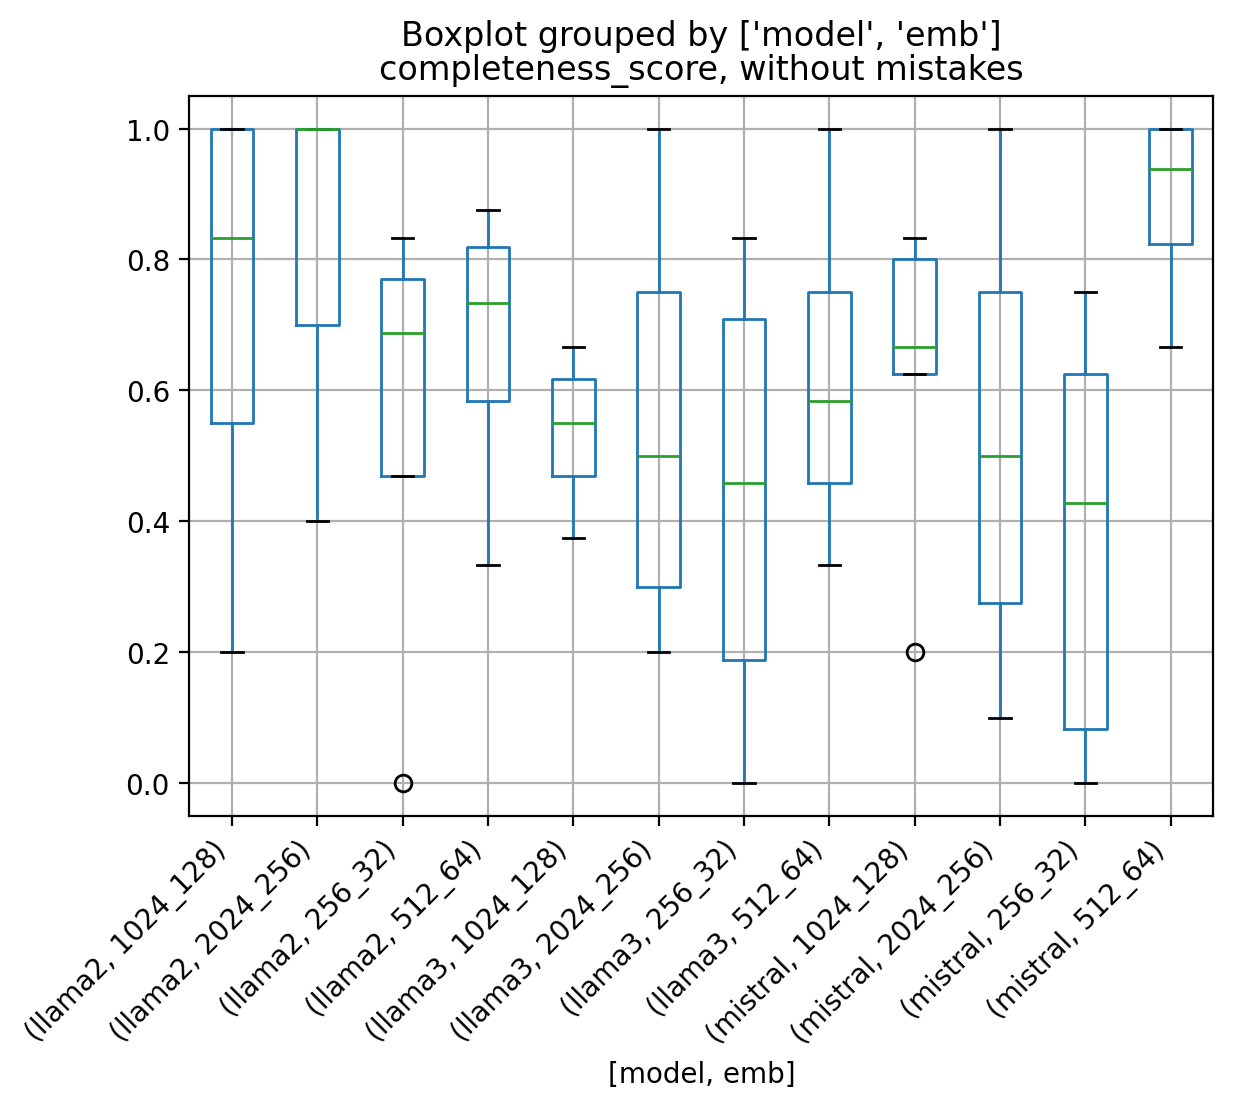

In [45]:
# without mistakes, cnd_is_correct
aggr = ['model', 'emb']
plot_df = dfs[cnd_is_correct][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
plt.title("completeness_score, without mistakes")
pd.concat({"correct answers only" : summary_df}, axis=1).head()

,,wo hallucinations
,,completeness_score
model,emb,
llama2,2024_256,0.572222
mistral,512_64,0.532143
llama2,1024_128,0.495238
mistral,1024_128,0.472403
llama3,2024_256,0.450000


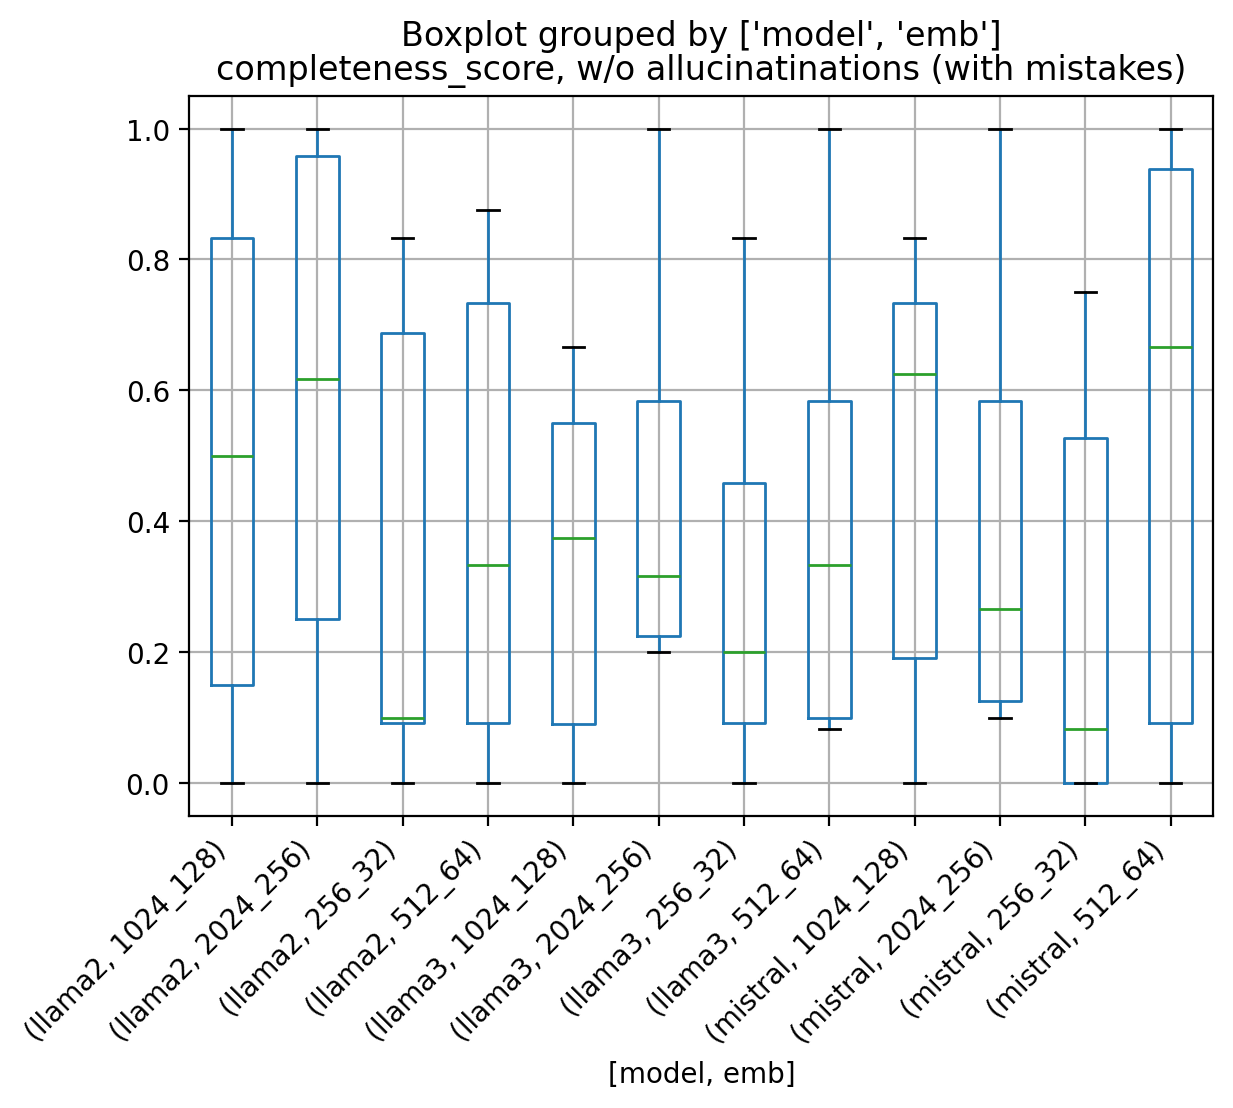

In [46]:
# wo hallucinations, cnd_wo_hallucinations
aggr = ['model', 'emb']
plot_df = dfs[cnd_wo_hallucinations][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
plt.title("completeness_score, w/o allucinatinations (with mistakes)")
pd.concat({"wo hallucinations" : summary_df}, axis=1).head()


wo hallucinations/mistakes, non complex
                                      completeness_score
model   emb                                             
mistral 512_64                                  0.885417
llama2  2024_256                                0.800000
        1024_128                                0.716667
        512_64                                  0.668750
llama3  512_64                                  0.625000

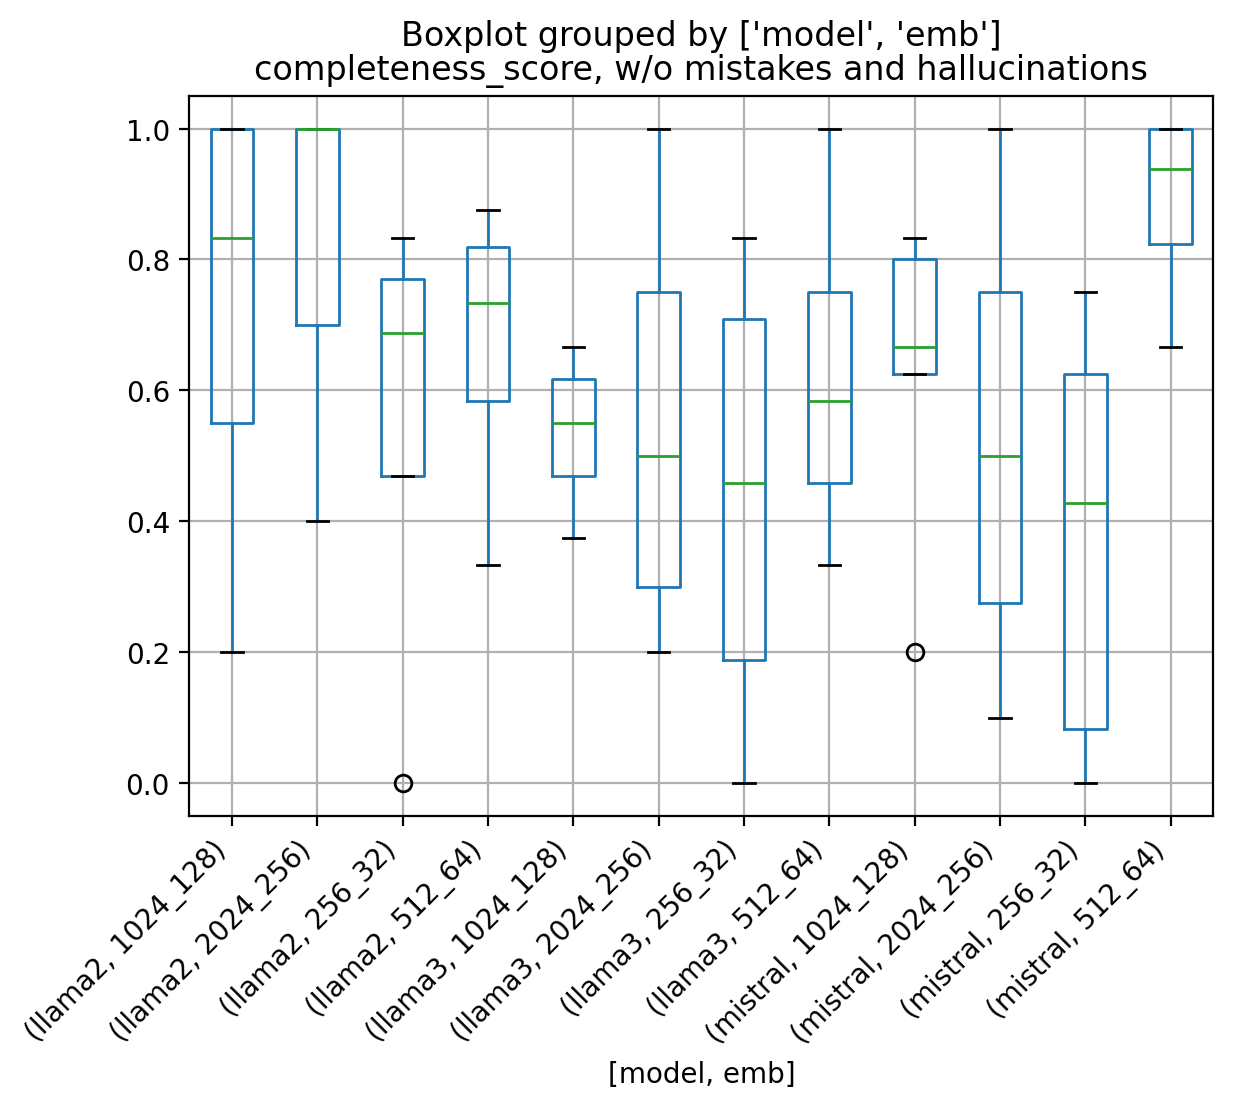

In [43]:
# wo hallucinations, wo mistakes, cnd_wo_hallucinations & cnd_is_correct, by model and emb (text chunk)
aggr = ['model', 'emb']
plot_df = dfs[cnd_wo_hallucinations & cnd_is_correct][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
plt.title("completeness_score, w/o mistakes and hallucinations")
pd.concat({"wo hallucinations/mistakes, non complex" : summary_df}, axis=1).head()

,,"wo hallucinations/mistakes, non complex"
,,completeness_score
emb,model,
512_64,mistral,0.885417
2024_256,llama2,0.800000
1024_128,llama2,0.716667
512_64,llama2,0.668750
1024_128,mistral,0.625000


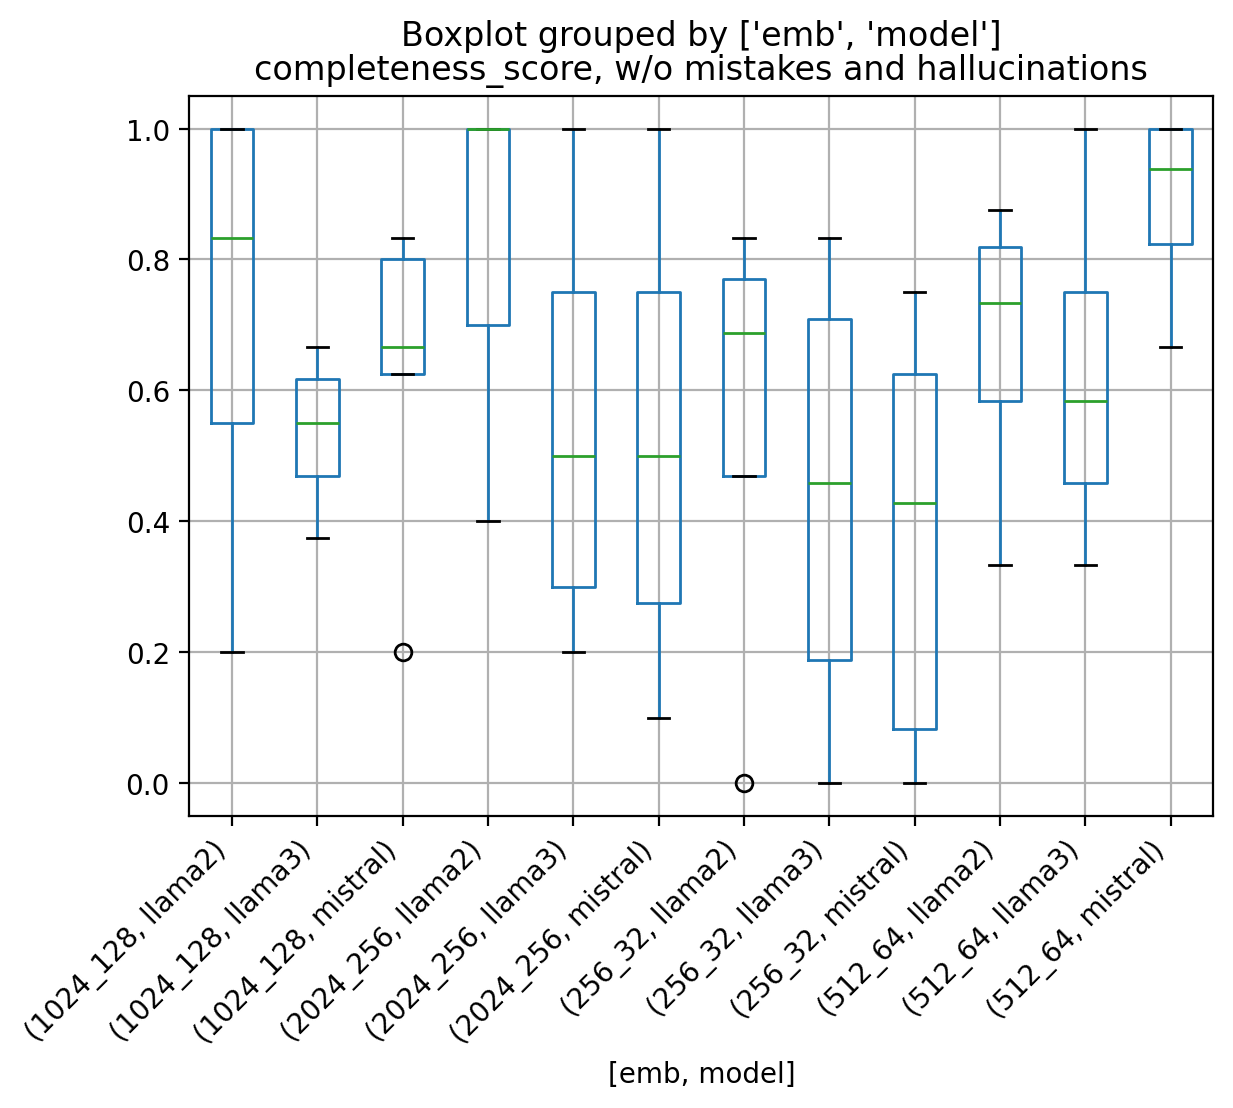

In [42]:
# wo hallucinations, wo mistakes; cnd_wo_hallucinations & cnd_is_correct, by emb, model
aggr = ['emb', 'model']
plot_df = dfs[cnd_wo_hallucinations & cnd_is_correct][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
plt.title("completeness_score, w/o mistakes and hallucinations")
pd.concat({"wo hallucinations/mistakes, non complex" : summary_df}, axis=1).head()

wo hallucinations/mistakes, non complex
                                      completeness_score
emb      model                                          
2024_256 llama2                                 0.344444
         llama3                                 0.250000
1024_128 llama2                                 0.200000
2024_256 mistral                                0.150000
256_32   llama3                                 0.127778

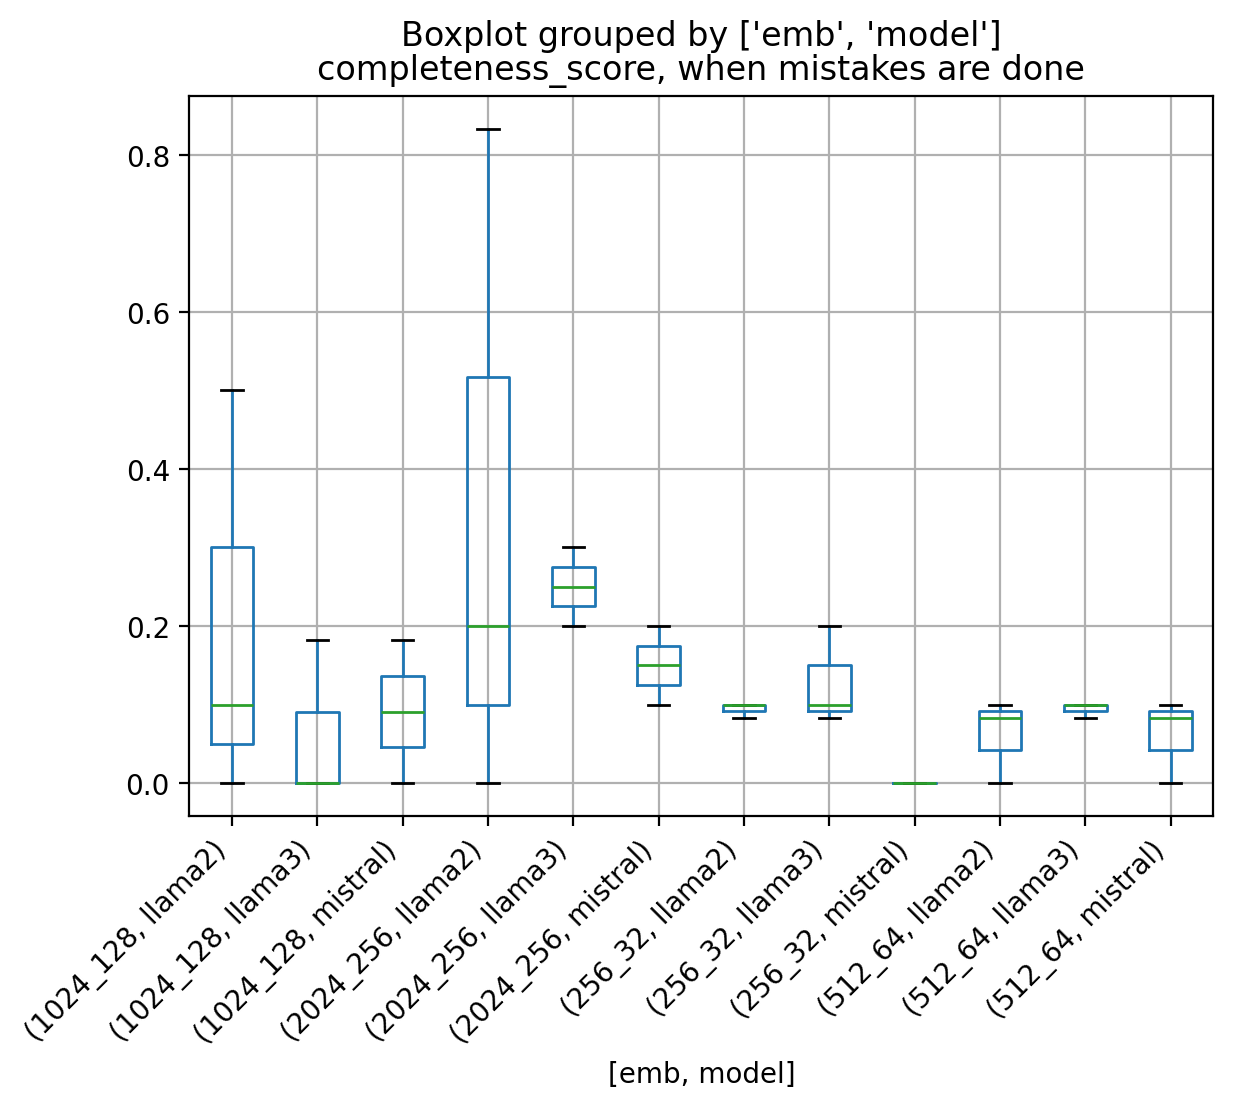

In [41]:
# completeness_score, with mistakes
aggr = ['emb', 'model']
plot_df = dfs[cnd_is_incorrect][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
plt.title("completeness_score, when mistakes are done")
pd.concat({"wo hallucinations/mistakes, non complex" : summary_df}, axis=1).head()

## complex (open) query

,,complex query
,,completeness_score
model,emb,
llama3,2024_256,0.233333
llama2,2024_256,0.200000
mistral,2024_256,0.133333
llama3,256_32,0.127778
mistral,1024_128,0.127273


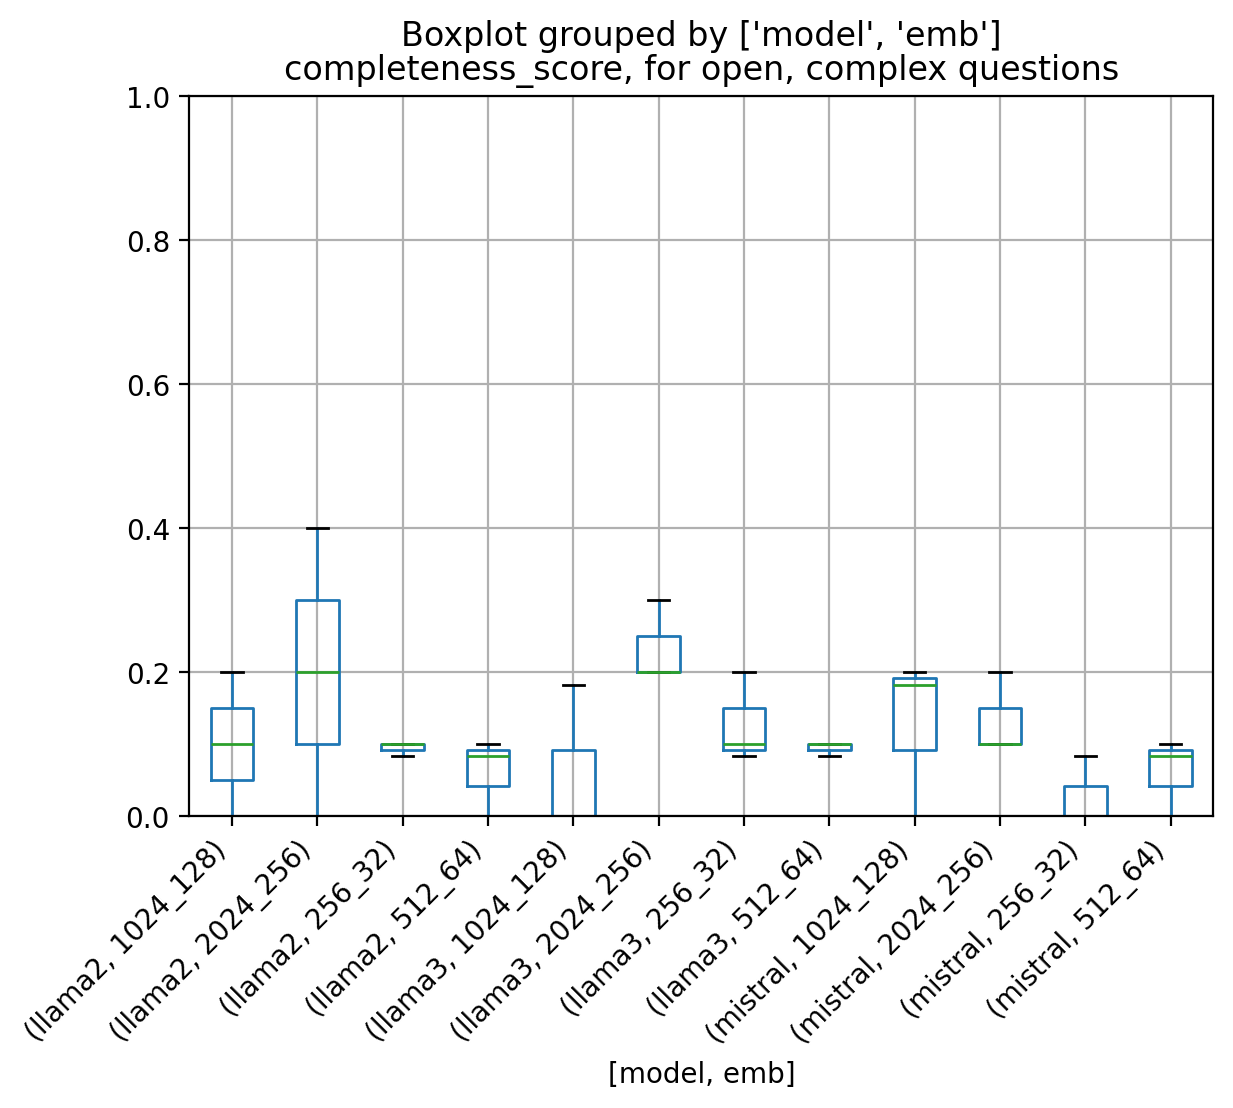

In [40]:
# is complex, cnd_is_complex_q
aggr = ['model', 'emb']
plot_df = dfs[cnd_is_complex_q][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
plt.ylim(0,1)
summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
plt.title("completeness_score, for open, complex questions")
pd.concat({"complex query" : summary_df}, axis=1).head()

In [25]:
dfs.shape

(81, 17)

In [26]:
# model with more / less mistakes
dfs[['model', 'emb', 'incorrect_information']].groupby(['model', 'emb']).count().sort_values(by='incorrect_information', ascending=False)

incorrect_information
model   emb                            
llama2  1024_128                      7
        256_32                        7
        512_64                        7
llama3  1024_128                      7
        256_32                        7
        512_64                        7
mistral 1024_128                      7
        256_32                        7
        512_64                        7
llama2  2024_256                      6
llama3  2024_256                      6
mistral 2024_256                      6

In [27]:
# model with more / less mistakes
dfs[cnd_is_complex_q==False][['model', 'emb', 'incorrect_information']].groupby(['model', 'emb']).count().sort_values(by='incorrect_information', ascending=False)

incorrect_information
model   emb                            
llama2  1024_128                      4
        256_32                        4
        512_64                        4
llama3  1024_128                      4
        256_32                        4
        512_64                        4
mistral 1024_128                      4
        256_32                        4
        512_64                        4
llama2  2024_256                      3
llama3  2024_256                      3
mistral 2024_256                      3

,query_survey,model,emb,completeness_score,k
45,q6_acceptance SA,mistral,256_32,0.083333,3
46,q6_acceptance SA,llama2,256_32,0.083333,3
47,q6_acceptance SA,llama3,256_32,0.083333,3
48,q6_acceptance SA,mistral,512_64,0.083333,3
49,q6_acceptance SA,llama2,512_64,0.083333,3


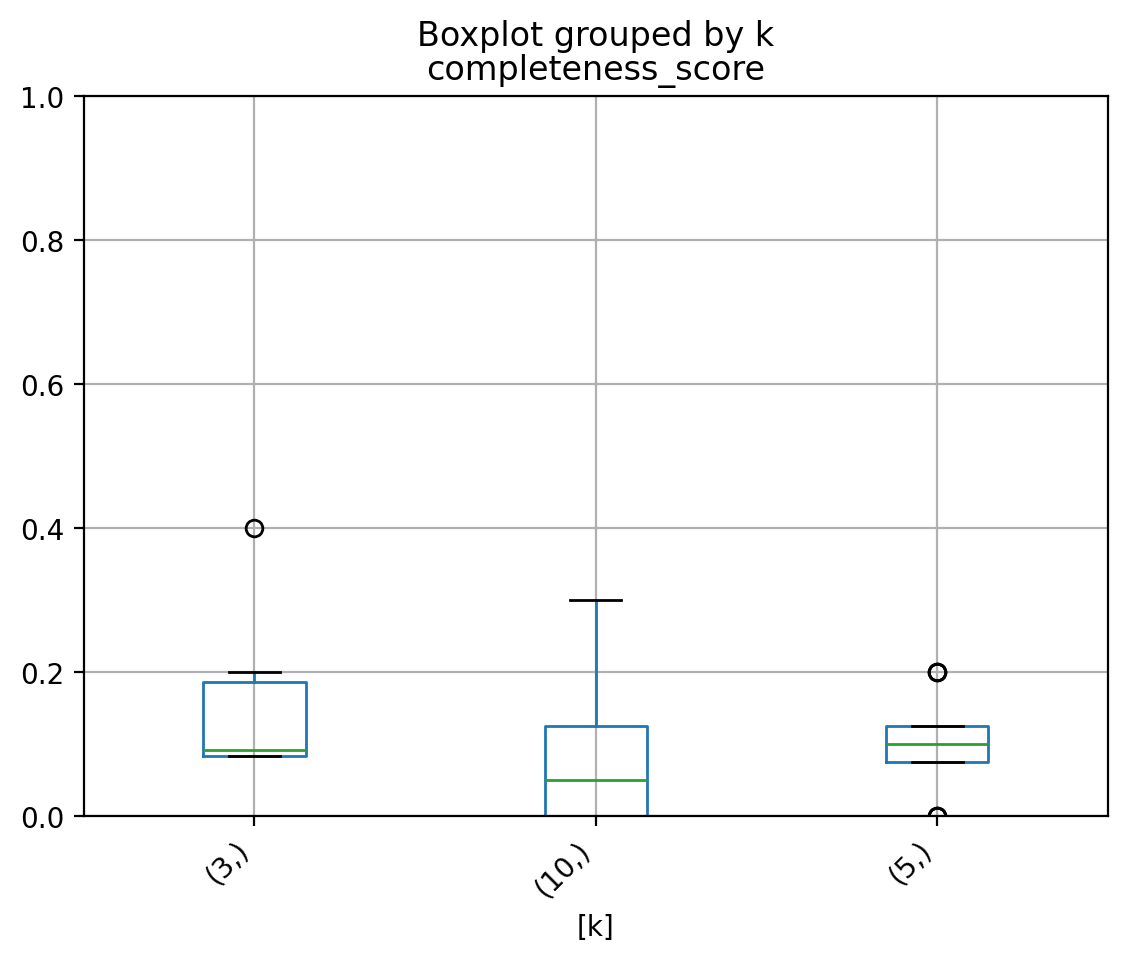

In [28]:
# effect of k on complex q
plot_df = dfs[cnd_is_complex_q][['query_survey', 'model', 'emb', 'completeness_score']]
plot_df['k'] = plot_df['query_survey'].apply(lambda X: X.split("_k")).apply(lambda X: X[-1] if len(X) > 1 else 3)
display(plot_df.head(5))

# is complex
#aggr = ['k', 'model']
aggr = ['k']
#plot_df = dfs[cnd_is_complex_q][['model', 'emb', 'completeness_score']].sort_values(by='completeness_score')
plot_df.boxplot(column='completeness_score', by=aggr)
plt.xticks(rotation=45, ha='right');
plt.ylim(0,1), plt.show();
#summary_df = plot_df.groupby(aggr).mean().sort_values(by='completeness_score', ascending=False)
#pd.concat({"complex query" : summary_df}, axis=1).head()


### best performer are:
> - llama2 with 2024_256<br>
> - mistral with 512_64 <br>
<br>
> - increasing k with an open / complex question, didn't improve the performance, k=3 seems ok

I will produce embeddings for both models